In [3]:
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

print('Libraries imported.')

import pandas as pd

Libraries imported.


In [4]:
import boto3
import botocore
from sagemaker import get_execution_role
import sagemaker

In [5]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket_name = 'deploy-sagemaker-conversation'


s3_url = 's3://deploy-sagemaker-conversation/floop_data_15k.json'
conn = boto3.client('s3')
contents = conn.list_objects(Bucket = bucket_name)['Contents']

s3 = boto3.resource('s3')

In [6]:
import json
from sagemaker import get_execution_role

In [7]:

s3_client = boto3.client('s3')


In [8]:
# s3_client.list_objects(Bucket = bucket_name)['Contents']


In [9]:

dataset = conn.get_object(Bucket = bucket_name, Key = 'floop_data_15k.json')


In [10]:

s3_client.get_object(Bucket = bucket_name, Key = 'floop_data_15k.json')

{'ResponseMetadata': {'RequestId': 'X566KSZ2YPMGTTMZ',
  'HostId': '1Lkxnlvm6mIYg4ojdSJ19Jnqa19Pv5vzhGIqzL8ODNIabqziqli28aDrg7SKhX2JS6buKINEiWo=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '1Lkxnlvm6mIYg4ojdSJ19Jnqa19Pv5vzhGIqzL8ODNIabqziqli28aDrg7SKhX2JS6buKINEiWo=',
   'x-amz-request-id': 'X566KSZ2YPMGTTMZ',
   'date': 'Tue, 08 Mar 2022 01:49:04 GMT',
   'last-modified': 'Sun, 27 Feb 2022 17:35:56 GMT',
   'etag': '"df723040ec35ba55ac530b7af5406251"',
   'accept-ranges': 'bytes',
   'content-type': 'application/json',
   'server': 'AmazonS3',
   'content-length': '787897'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2022, 2, 27, 17, 35, 56, tzinfo=tzutc()),
 'ContentLength': 787897,
 'ETag': '"df723040ec35ba55ac530b7af5406251"',
 'ContentType': 'application/json',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f30e6880c18>}

In [11]:
# Reading the Json file and convert to an list.


path = 's3://deploy-sagemaker-conversation/floop_data_15k.json'
dataset = pd.read_json(path).values.tolist()
print('Dataset imported')

INFO - 01:49:05: ascii passed initial chaos probing. Mean measured chaos is 0.000000 %
INFO - 01:49:05: ascii should target any language(s) of ['Latin Based']
INFO - 01:49:05: We detected language [('English', 0.9048), ('Indonesian', 0.8571), ('Simple English', 0.8571)] using ascii
INFO - 01:49:05: ascii is most likely the one. Stopping the process.
INFO - 01:49:05: ascii passed initial chaos probing. Mean measured chaos is 0.000000 %
INFO - 01:49:05: ascii should target any language(s) of ['Latin Based']
INFO - 01:49:05: We detected language [('German', 0.8333), ('Hungarian', 0.8333), ('Slovak', 0.8333), ('English', 0.75), ('Dutch', 0.75), ('Italian', 0.75), ('Swedish', 0.75), ('Norwegian', 0.75), ('Czech', 0.75), ('Indonesian', 0.75), ('Danish', 0.75), ('Polish', 0.6667), ('Finnish', 0.6667), ('Slovene', 0.6667), ('Turkish', 0.5833), ('Vietnamese', 0.5), ('Lithuanian', 0.5)] using ascii
INFO - 01:49:05: ascii is most likely the one. Stopping the process.
INFO - 01:49:05: ascii passed

Dataset imported


In [12]:
def clean_dataset(dataset):
    
    new_ds = map(lambda x: x[0].lower(),dataset)    

    return list(new_ds)


new_ds = clean_dataset(dataset)
print('Cleaned dataset')

Cleaned dataset


In [13]:
def sentiment_analysis(sentiment_text):
    score = SentimentIntensityAnalyzer().polarity_scores(sentiment_text)
    if score['neg'] > score['pos']:
        return 'Negative'
    elif score['neg'] < score['pos']:
        return 'Positive'
    else:
        return 'Neutral'

In [14]:
# Define an list
sentiments = []
for i in new_ds:
    sentiments.append(sentiment_analysis(i))

In [15]:
result = pd.DataFrame({'Original Data':dataset, 'Sentiment Identified':sentiments})

                                           Original Data Sentiment Identified
0                                   [What is this word?]              Neutral
1                                      [pronoun problem]             Negative
2                                                  [s-v]              Neutral
3      [Use textual language  and quality words and p...              Neutral
4      [If the temperature in a pond is lower, then t...             Positive
...                                                  ...                  ...
15612                                      [#9 is good!]             Positive
15613  [#9 good explanation (also: your first stateme...             Positive
15614   [#9 is best classified as an addition reaction.]             Positive
15615  [#9 good catch on this one, it is No Solution ...             Positive
15616  [#9 does not indicate greater than and it should]             Negative

[15617 rows x 2 columns]
Neutral     11331
Positive     2777
Ne

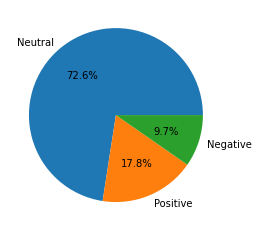

In [16]:
result.to_csv('results.csv')

print(result)

print(result['Sentiment Identified'].value_counts())
plt.pie(result['Sentiment Identified'].value_counts(), labels = result['Sentiment Identified'].value_counts().keys(), autopct='%.1f%%')
plt.show()

In [24]:
s3_output = s3.Object(bucket_name,'floop_data_15k.json')

In [25]:
json_output = json.dumps(format(result))

In [27]:
s3_output.put(Body=(bytes(json.dumps( json_output).encode('UTF-8'))), ContentType='application/json')

{'ResponseMetadata': {'RequestId': 'FSFVB0GP6C64QFM3',
  'HostId': 'WpJEOJDQwwTKNPC9jnYuyHc5DeJKl/TT5joQBo+vn9yZ+rwytFhaL5GKgUyKI4cLMRwsvLZ2P4k=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'WpJEOJDQwwTKNPC9jnYuyHc5DeJKl/TT5joQBo+vn9yZ+rwytFhaL5GKgUyKI4cLMRwsvLZ2P4k=',
   'x-amz-request-id': 'FSFVB0GP6C64QFM3',
   'date': 'Tue, 08 Mar 2022 03:23:32 GMT',
   'etag': '"a3348404dcdd900858622b6b828be02d"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"a3348404dcdd900858622b6b828be02d"'}